Import Required libraries

In [ ]:
#install the yahoo finance  
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.3MB 11.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=cecf2ac7c4579995add9b66782e1d347fc8c52d03ac963f2fbef0343d9ca3000
  Stored in directory: /tmp/pip-ephem-wheel-cache-7bccr0fr/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
!pip install -U "scikit-learn==0.24"

     |████████████████████████████████| 22.3MB 69.1MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf
yf.pdr_override()
import numpy as np
np.random.seed(7)
import pandas as pd
import math
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, SimpleRNN,Dense,Dropout
from keras import optimizers
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from keras.layers.recurrent import LSTM
from sklearn.metrics import accuracy_score
import os.path
from os import path
import numpy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from sklearn.metrics import mean_absolute_percentage_error
import keras
keras.backend.set_epsilon(1)

Collect the data

In [ ]:
#https://finance.yahoo.com/sector/ms_financial_services
ticker_list=['BRK-B','BRK-A','MSFT','AAPL','FB','JPM']
today = date.today()
l = len(ticker_list)
df_dict = {} # creating a dictionay for the data
files=[]
sector=[]
for i in range(0,l):
  sector = yf.Ticker(ticker_list[i]).info['sector']
  if path.exists('./'+sector) == False:
    os.mkdir('./'+sector)
  else:
    print("folder already exist");
# we are getting the data with a start and end
def getData(ticker):
  print(ticker)
  data = pdr.get_data_yahoo(ticker, start="2020-01-01", end="2021-05-17")
  df_dict[ticker] = data # storing the data frames in the dictionary
  dataname= ticker+'_'+str(today)
  files.append(dataname)
  SaveData(data, dataname,yf.Ticker(ticker).info['sector'])

# we are having the data based on the sector of the company
  
def SaveData(df, filename,sector):
  if (sector == 'Financial Services'):
    df.to_csv('./Financial Services/'+filename+'.csv')
  elif (sector == 'Technology'):
    df.to_csv('./Technology/'+filename+'.csv')
  elif (sector == 'Communication Services'):
    df.to_csv('./Communication Services/'+filename+'.csv')
  else:
    print("sector is not being considered");

for ticker in ticker_list:
  getData(ticker)


folder already exist
folder already exist
folder already exist
BRK-B
[*********************100%***********************]  1 of 1 completed
BRK-A
[*********************100%***********************]  1 of 1 completed
MSFT
[*********************100%***********************]  1 of 1 completed
AAPL
[*********************100%***********************]  1 of 1 completed
FB
[*********************100%***********************]  1 of 1 completed
JPM
[*********************100%***********************]  1 of 1 completed


Preprocess the data

In [ ]:

# finding the features with highest correlation with the close feature
company = 'JPM'
df_dict[company].corr()['Adj Close']

Open         0.994448
High         0.996137
Low          0.996081
Close        0.997893
Adj Close    1.000000
Volume      -0.437272
Name: Adj Close, dtype: float64

In [ ]:

df_dict[company].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,139.789993,141.100006,139.259995,141.089996,134.380966,10803700
2020-01-03,137.500000,139.229996,137.080002,138.339996,132.607590,10386800
2020-01-06,136.559998,138.270004,136.500000,138.229996,132.502167,10259000
2020-01-07,137.279999,137.860001,135.820007,135.880005,130.249542,10531300
2020-01-08,135.699997,137.580002,135.600006,136.940002,131.265610,9695300


In [ ]:
# we are considering a subset of company featues but we can consider only positively correlated features
df=df_dict[company].reset_index()[['Adj Close', 'Close']]
df

,Adj Close,Close
0,134.380966,141.089996
1,132.607590,138.339996
2,132.502167,138.229996
3,130.249542,135.880005
4,131.265610,136.940002
...,...,...
340,161.220001,161.220001
341,158.539993,158.539993
342,157.449997,157.449997
343,161.500000,161.500000


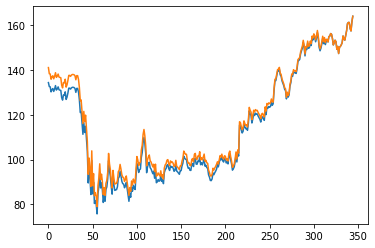

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df)

In [ ]:

#normalize the data using minMaxScalar
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [ ]:
#split dataset into train and test 
split = 0.80
training_size=int(len(df)*split)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]

In [ ]:
training_size,test_size

(552, 138)

In [ ]:
# converting data into the time_step data
def timestep_data(dataset, time_step=1):
	data_input, data_output = [], []
	for i in range(len(dataset)-time_step-1):
		data1 = dataset[i:(i+time_step), 0]   
		data_input.append(data1)
		data_output.append(dataset[i + time_step, 0])
	return np.array(data_input), np.array(data_output)

In [ ]:
# we take a previous memory i.e set to values without dependence on the data here it is 30
time_step = 30
x_train, y_train = timestep_data(train_data, time_step)
x_test, y_test = timestep_data(test_data, time_step)

In [ ]:
print("x_train shape ",x_train.shape,"y_train shape", y_train.shape,"x_test shape",x_test.shape,"y_test shape",y_test.shape)

x_train shape  (521, 30) y_train shape (521,) x_test shape (107, 30) y_test shape (107,)


In [ ]:
#reshape the data before sending it ot the model

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

In [ ]:
#hyperparameters
lr = 1e-3
batch_size = 64
num_epochs = 250
hl = [50,45]

Model

In [ ]:
# for rnn model 
model = Sequential()
model.add(SimpleRNN(x_train.shape[2],input_shape = (x_train.shape[1],x_train.shape[2]),return_sequences = True,
                        activation = 'relu'))
for i in range(len(hl)-1):        
  model.add(SimpleRNN(hl[i],activation = 'relu',return_sequences = True))

model.add(SimpleRNN(hl[-1],activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error' )





In [ ]:
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=num_epochs,batch_size=batch_size,verbose=1)

Epoch 1/250
9/9 [==============================] - 5s 128ms/step - loss: 0.0685 - val_loss: 0.0034
Epoch 2/250
9/9 [==============================] - 0s 54ms/step - loss: 0.0101 - val_loss: 0.0136
Epoch 3/250
9/9 [==============================] - 0s 56ms/step - loss: 0.0045 - val_loss: 0.0135
Epoch 4/250
9/9 [==============================] - 1s 61ms/step - loss: 0.0033 - val_loss: 8.4782e-04
Epoch 5/250
9/9 [==============================] - 0s 55ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 6/250
9/9 [==============================] - 1s 55ms/step - loss: 0.0026 - val_loss: 7.6186e-04
Epoch 7/250
9/9 [==============================] - 1s 57ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 8/250
9/9 [==============================] - 1s 65ms/step - loss: 0.0020 - val_loss: 7.6584e-04
Epoch 9/250
9/9 [==============================] - 1s 58ms/step - loss: 0.0019 - val_loss: 6.7404e-04
Epoch 10/250
9/9 [==============================] - 0s 56ms/step - loss: 0.0018 - val_loss: 6.0748e-0

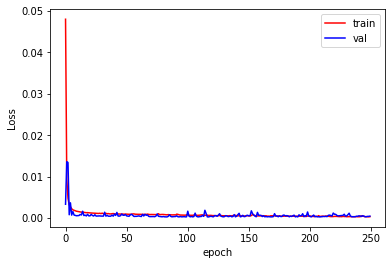

In [ ]:
plt.plot( history.history['loss'],c = 'r')
plt.plot(history.history['val_loss'],c = 'b')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train','val'],loc = 'upper right')
plt.show()

In [ ]:
# predict the train and test data
predict_train=model.predict(x_train)
predict_test=model.predict(x_test)

In [ ]:
# metrics for model
rsme = math.sqrt(mean_squared_error(y_test,predict_test))*100
mape = mean_absolute_percentage_error(y_test,predict_test)*100
print("rsme",rsme)
print("mape",mape)

rsme 2.2623452348982402
mape 2.029841815830108


In [ ]:
#Transform to its original form
train_predict=scaler.inverse_transform(predict_train)
test_predict=scaler.inverse_transform(predict_test)

In [ ]:
# train predictions 

train_predicted_data = np.empty_like(df)
train_predicted_data[:, :] = np.nan
train_predicted_data[time_step:len(train_predict)+time_step, :] = train_predict

In [ ]:
# shift and the test predictions 
test_predicted_data = np.empty_like(df)
test_predicted_data[:, :] = numpy.nan
test_predicted_data[len(train_predict)+(time_step*2)+1:len(df)-1, :] = test_predict

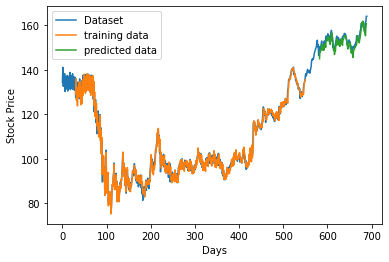

In [ ]:
#plot train and test predicted data together
plt.plot(scaler.inverse_transform(df), label='Dataset')
plt.plot(train_predicted_data, label = 'training data')
plt.plot(test_predicted_data, label = 'predicted data')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

predict stock prices for future dates

In [ ]:
# to predict the new data we are consider "no_of_steps" no of steps backwards i.e considering pervious time step no of vlues i.e 30
no_of_steps=time_step

In [ ]:
#convert to list to append future data
initial_input_data=test_data[(len(test_data)- no_of_steps):].reshape(1,-1)
input_data=list(initial_input_data)
input_data=input_data[0].tolist()

In [ ]:
#previous 30 days data
input_data

[0.8476003371102485,
 0.8476003371102485,
 0.8554186392160466,
 0.8554186392160466,
 0.8665228066805506,
 0.8665228066805506,
 0.9000621470298966,
 0.9000621470298966,
 0.8844255428183008,
 0.8844255428183008,
 0.8793267027607579,
 0.8793267027607579,
 0.9033480123886026,
 0.9033480123886026,
 0.9264630075618125,
 0.9264630075618125,
 0.9623817259204464,
 0.9623817259204464,
 0.968613718388458,
 0.968613718388458,
 0.9683870533274075,
 0.9683870533274075,
 0.938020332253634,
 0.938020332253634,
 0.9256697662955278,
 0.9256697662955278,
 0.97155967260298,
 0.97155967260298,
 0.9999999999999998,
 0.9999999999999998]

In [ ]:
# predicting values for the next 30 days 
future_output=[]

i=0
while(i<30):
    
    if(len(input_data)>30):
       
        # it is list of input for predicting the future day
        initial_input_data=np.array(input_data[1:])
        print("day {} : input data {}".format(i,initial_input_data))
        initial_input_data=initial_input_data.reshape(1,-1)
        initial_input_data = initial_input_data.reshape((1, no_of_steps, 1))
     
        
        # it is output of the future day
        yhat = model.predict(initial_input_data, verbose=0)
        print("day {} : predicted output data {}".format(i,yhat))
        input_data.extend(yhat[0].tolist())
        input_data=input_data[1:]
       
        # append the data with the present data
        future_output.extend(yhat.tolist())
        i=i+1
    else:
        # we are predicting 1st future day 
        initial_input_data= initial_input_data.reshape((1, no_of_steps,1))
        yhat = model.predict(initial_input_data, verbose=0)
        print(yhat[0])
        input_data.extend(yhat[0].tolist())
        print(len(input_data))
        future_output.extend(yhat.tolist())
        i=i+1
    

print(future_output)

[1.0063304]
31
day 1 : input data [0.84760034 0.85541864 0.85541864 0.86652281 0.86652281 0.90006215
 0.90006215 0.88442554 0.88442554 0.8793267  0.8793267  0.90334801
 0.90334801 0.92646301 0.92646301 0.96238173 0.96238173 0.96861372
 0.96861372 0.96838705 0.96838705 0.93802033 0.93802033 0.92566977
 0.92566977 0.97155967 0.97155967 1.         1.         1.00633037]
day 1 : predicted output data [[0.988446]]
day 2 : input data [0.85541864 0.85541864 0.86652281 0.86652281 0.90006215 0.90006215
 0.88442554 0.88442554 0.8793267  0.8793267  0.90334801 0.90334801
 0.92646301 0.92646301 0.96238173 0.96238173 0.96861372 0.96861372
 0.96838705 0.96838705 0.93802033 0.93802033 0.92566977 0.92566977
 0.97155967 0.97155967 1.         1.         1.00633037 0.988446  ]
day 2 : predicted output data [[0.9979354]]
day 3 : input data [0.85541864 0.86652281 0.86652281 0.90006215 0.90006215 0.88442554
 0.88442554 0.8793267  0.8793267  0.90334801 0.90334801 0.92646301
 0.92646301 0.96238173 0.96238173 0

Text(0, 0.5, 'normalized Stock Price')

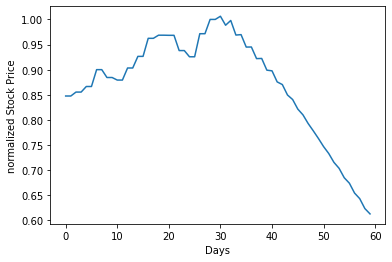

In [ ]:
# appending the future 30 days and plotting the graph
df1=df.tolist()
df1.extend(future_output)
plt.plot(df1[(len(df)-no_of_steps):])
plt.xlabel('Days')
plt.ylabel('normalized Stock Price')

In [ ]:
df2=scaler.inverse_transform(df1).tolist()

Text(0, 0.5, 'Stock Price')

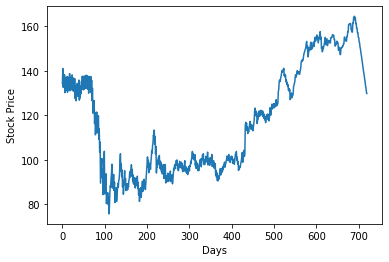

In [ ]:
# tranformed it back to original image with future 30 days
plt.plot(df2)
plt.xlabel('Days')
plt.ylabel('Stock Price')